# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 25 kB/s  eta 0:00:011


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error as mse
import time
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

In [3]:
#Загружаем данные в переменную
df = pd.read_csv('/datasets/autos.csv')

In [4]:
#Знакомимся с данными
df.info()

df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
#Проверим последнюю дату выгрузки анкеты из базы
df['DateCrawled'].max()

'2016-04-07 14:36:58'

Последняя дата выгрузки - 7 апреля 2016. Запомним эту дату, она может пригодиться в будущем для анализа.

In [6]:
#Проверяем наличие явных дубликатов
df.duplicated().sum()

4

In [7]:
#Удаляем явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)

#Проверяем
df.duplicated().sum()

0

In [8]:
#Удалим лишние столбцы
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1).reset_index(drop=True)

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [9]:
#Приведем столбцы к змеиному_регистру
df.columns = ['price',
              'vehicle_type',
              'registration_year',
              'gearbox',
              'power',
              'model',
              'kilometer',
              'registration_month',
              'fuel_type',
              'brand',
              'repaired']

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [10]:
#Проверяем кол-во пропуском в данных
missing = pd.DataFrame(
    {'Пропусков': df.isna().sum(),
     '%': (df.isna().sum() / len(df) * 100).round(2), 'Тип данных': df.dtypes})\
.sort_values(by='Пропусков', ascending=False)

display(missing)

,Пропусков,%,Тип данных
repaired,71154,20.08,object
vehicle_type,37490,10.58,object
fuel_type,32895,9.28,object
gearbox,19833,5.60,object
model,19705,5.56,object
price,0,0.00,int64
registration_year,0,0.00,int64
power,0,0.00,int64
kilometer,0,0.00,int64
registration_month,0,0.00,int64


Пропуски остались только в столбцах с текстовыми данными, что может говорить о том, что люди, заполнявшие данные, просто игнорировали ряд столбцов по тем или иным причинам. Например, пропуски в столбце `repaired`, вероятно, говорят об отсутствии ремонта.

In [11]:
#Изучим столбец 'repaired'
df['repaired'].value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

Поскольку столбец предполагает бинарные ответы да-нет, заменим ответы да на 1, а ответы нет на 0. Как говорили ранее, имеет смысл заменить пропуски на 0.

In [12]:
#Заполняем пропуски и меняем значения на 1 и 0
df['repaired'] = df['repaired'].fillna(0)
df['repaired'] = df['repaired'].replace({'yes':1, 'no':0})

#Проверяем
df['repaired'].value_counts()

0    318312
1     36053
Name: repaired, dtype: int64

In [13]:
#Проверим количество строк с пропусками во всех 4 столбцах
missing_rows = df[[
    'vehicle_type',
    'fuel_type',
    'model',
    'gearbox']].isna().all(axis=1).sum()

missing_rows

2392

Такие строки лучше удалить, слишком много отсутствующих данных, которые могут повлиять на обучение модели.

In [14]:
#Удаляем
df = df.dropna(subset=[
    'vehicle_type',
    'fuel_type',
    'model',
    'gearbox'], how='all').reset_index(drop=True)

Остальные пропуски, чтобы не удалять слишком много данных, заменим на `unknown`

In [15]:
#Заменяем пропуски
df = df.fillna('unknown')

#Проверяем
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

Проверим информацию в других столбцах.

In [16]:
#Смотрим значения столбца с месяцем регистрации
df['registration_month'].value_counts()

0     35302
3     34351
6     31481
4     29244
5     29122
7     27187
10    26085
12    24254
11    24171
9     23800
1     23127
8     22598
2     21251
Name: registration_month, dtype: int64

Налицо ошибка в данных - месяцев может быть не более 12, в нашем случае есть нулевой месяц, на который приходится больше всего строк. Ничего толкового мы с этим сделать не можем, поэтому оставим как есть.

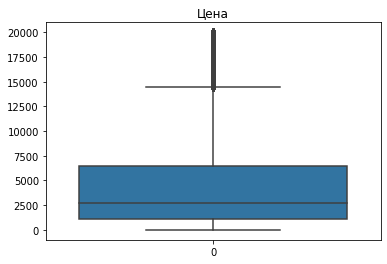

In [17]:
#Изучим значения столбца 'price'
sns.boxplot(data=df['price'])
plt.title('Цена')
plt.show()

Есть как нулевые значения, так и выбросы после 15 тысяч. Избавимся от них, чтобы не издеваться над будущими моделями машинного обучения.

In [18]:
#Удалим строки с выбросами
df = df.query('price < 16000 & price > 100')

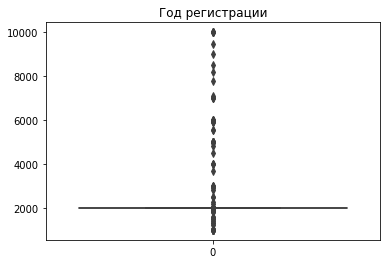

In [19]:
#Изучим значения столбца 'registration_year'
sns.boxplot(data=df['registration_year'])
plt.title('Год регистрации')
plt.show()

Наблюдаем чудовищное количество выбросов. Строки с выбросами стоит также удалить. Вспоминаем, что последняя дата скачивания анкеты в 2016 году, поэтому убираем все, что было позже.

In [20]:
#Удалим строки с выбросами
df = df.query('registration_year < 2017 & registration_year > 1960')

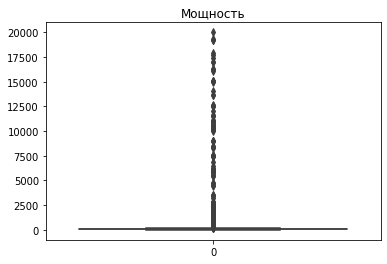

In [21]:
#Изучим значения столбца 'power'
sns.boxplot(data=df['power'])
plt.title('Мощность')
plt.show()

Снова сумасшедшие выбросы по мощности. Удалим.

In [22]:
#Удалим строки с выбросами
df = df.query('power < 500 & power > 50')

In [23]:
#Посмотрим на значения столбца с пробегом
df['kilometer'].unique()

array([125000, 150000,  90000,  30000, 100000,  60000,  70000,  80000,
         5000,  50000,  40000,  20000,  10000])

Ничего необычного, идем дальше.

После очистки данных от выбросов проверим на корреляцию числовых столбцов.

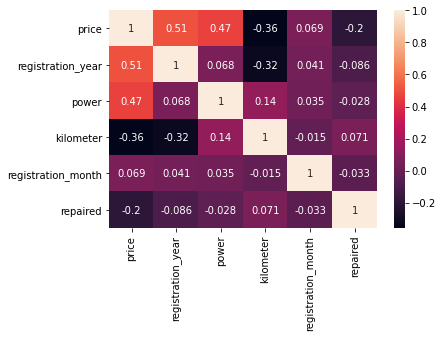

In [24]:
#Проверим корреляцию столбцов
sns.heatmap(df.corr(), annot=True);

Откровенно сильной корреляции не наблюдается, однако целевая метрика (цена) положительно коррелирует с годом регистрации авто и его мощностью и отрицательно с пробегом. Всё логично. Дополнительно удалим столбец `registration month`, т.к. он будет только мешать моделям обучаться и никак не влияет на цену.

In [25]:
#Удаляем столбец
df = df.drop(['registration_month'], axis=1)

#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274015 entries, 2 to 351972
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              274015 non-null  int64 
 1   vehicle_type       274015 non-null  object
 2   registration_year  274015 non-null  int64 
 3   gearbox            274015 non-null  object
 4   power              274015 non-null  int64 
 5   model              274015 non-null  object
 6   kilometer          274015 non-null  int64 
 7   fuel_type          274015 non-null  object
 8   brand              274015 non-null  object
 9   repaired           274015 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 23.0+ MB


Мы достаточно подготовили данные к работе:
- переименовали столбцы для соответствия змеиному_регистру
- обнаружили и удалили явные дубликаты
- удалили лишние столбцы
- заполнили пропуски
- удалили очень много "мусорных" данных (выбросов)

Переходим к обучению моделей.

## Обучение моделей

In [26]:
#Создадим переменные features и target
features = df.drop(['price'], axis=1)

target = df['price']

#Проверяем
print(features.shape)
print(target.shape)

(274015, 9)
(274015,)


In [27]:
#Разделим features и target на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=12345
)

#Проверяем
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(219212, 9)
(219212,)
(54803, 9)
(54803,)


In [28]:
#Кодируем столбцы brand и model через TargetEncoder
encoder = TargetEncoder(cols=['brand', 'model'])

features_train_encoded = encoder.fit_transform(features_train, target_train)
features_test_encoded = encoder.transform(features_test)

#Применяем OHE к категориальным признакам
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

features_train_ohe = ohe.fit_transform(features_train_encoded.select_dtypes(include='object'))
features_test_ohe = ohe.transform(features_test_encoded.select_dtypes(include='object'))

features_train_final = np.concatenate([features_train_ohe, features_train.select_dtypes(include='int64')], axis=1)
features_test_final = np.concatenate([features_test_ohe, features_test.select_dtypes(include='int64')], axis=1)

#Проверим результат
print(features_train_final.shape)
print(features_test_final.shape)

(219212, 24)
(54803, 24)


In [29]:
#Масштабируем признаки
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_final)
features_test_scaled = scaler.transform(features_test_final)

Теперь можем приступить к обучению моделей. Выбранные нами модели долго обучаются, но очень быстро предсказывают - от десятых долей до нескольких секунд. Поэтому нас в первую очередь будет интересовать именно время обучения. Время предсказания мы посмотрим на лучшей модели из трех, когда протестируем ее на тестовой выборке.

In [30]:
#Создадим модель линейной регрессии 
regression_params = {'normalize': [True, False]}

regression = LinearRegression()
regression_random_search = RandomizedSearchCV(
    regression,
    param_distributions=regression_params,
    n_iter=2,
    cv=3,
    random_state=12345)

start_time = time.time()
regression_random_search.fit(features_train_scaled, target_train)
end_time = time.time()
regression_training_time = end_time - start_time
best_regression_model = regression_random_search.best_estimator_

print(f'Время обучения модели линейной регрессии: {regression_training_time}')

Время обучения модели линейной регрессии: 2.9829890727996826


In [31]:
#Проверим RMSE модели линейной регрессии
rmse_regression = -cross_val_score(
    best_regression_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=3).mean()

print(f'RMSE лучшей модели линейной регрессии: {rmse_regression}')

RMSE лучшей модели линейной регрессии: 2443.1513208839337


In [32]:
#Создадим модель градиентного бустинга с помощью LightGBM 
lgbmr_params = {
    'n_estimators': [50],
    'max_depth': [1, 3]
}

lgbmr = lgb.LGBMRegressor()
lgbmr_random_search = RandomizedSearchCV(
    lgbmr,
    param_distributions=lgbmr_params,
    n_iter=2,
    cv=3,
    random_state=12345)

start_time = time.time()
lgbmr_random_search.fit(features_train_scaled, target_train)
end_time = time.time()
lgbmr_training_time = end_time - start_time
best_lgbmr_model = lgbmr_random_search.best_estimator_

print(f'Время обучения LightGBM модели: {lgbmr_training_time}')

Время обучения LightGBM модели: 348.70595026016235


In [33]:
#Проверим RMSE модели LightGBM
rmse_lgbmr = -cross_val_score(
    best_lgbmr_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=3).mean()

print(f'RMSE лучшей LightGBM модели: {rmse_lgbmr}')

RMSE лучшей LightGBM модели: 1858.7069851274493


In [34]:
#Создадим модель градиентного бустинга CatBoostRegressor 
catboost_params = {
    'depth': [1, 3]
}

catboost = CatBoostRegressor(verbose=False)
catboost_random_search = RandomizedSearchCV(
    catboost,
    param_distributions=catboost_params,
    n_iter=2,
    cv=3,
    random_state=12345)

start_time = time.time()
catboost_random_search.fit(features_train_scaled, target_train)
end_time = time.time()
catboost_training_time = end_time - start_time
best_catboost_model = catboost_random_search.best_estimator_

print(f'Время обучения CatBoost модели: {catboost_training_time}')

Время обучения CatBoost модели: 106.06970191001892


In [35]:
#Проверим RMSE модели CatBoost
rmse_catboost = -cross_val_score(
    best_catboost_model,
    features_train_scaled,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=3).mean()

print(f'RMSE лучшей CatBoost модели: {rmse_catboost}')

RMSE лучшей CatBoost модели: 1694.9418489942072


## Анализ моделей

Мы обучили три вида моделей и посчитали лучшие показали RMSE. Результаты следующие

In [36]:
#Собираем таблицу с отчетом
results = [
    {'Время обучения': round(lgbmr_training_time),
     'RMSE': round(rmse_lgbmr)},    
    {'Время обучения': round(catboost_training_time),
     'RMSE': round(rmse_catboost)},
    {'Время обучения': round(regression_training_time),
     'RMSE': round(rmse_regression)}
]

pd.DataFrame(data=results,
             index=['LightGBM', 'CatBoost', 'LinearRegression'],
             columns=['Время обучения', 'RMSE'])

,Время обучения,RMSE
LightGBM,349,1859
CatBoost,106,1695
LinearRegression,3,2443


Лучше всего себя показала модель CatBoost - её время обучения почти в 2 раза меньше модели LightGBM при лучшем результате RMSE. LightGBM показала себя похуже, но проходит по условию в показатель RMSE ниже 2500. Модель линейной регрессии обучилась молниеносно, однако RMSE едва ниже 2500, но и она проходит.

Выберем CatBoost для подсчета RMSE и времени предсказания на тестовой выборке.

In [37]:
#Посчитаем RMSE на тестовой выборке
start_time = time.time()
test_predictions = best_catboost_model.predict(features_test_scaled)
end_time = time.time()
catboost_predicting_time = end_time - start_time

rmse_catboost_final = (mse(target_test, test_predictions)**0.5).round(1)

print(f'RMSE CatBoost модели на тестовой выборке: {rmse_catboost_final}')
print(f'Время предсказания CatBoost модели на тестовой выборке: {catboost_predicting_time}')

RMSE CatBoost модели на тестовой выборке: 1675.5
Время предсказания CatBoost модели на тестовой выборке: 0.30190014839172363


**Общий вывод:**

Результатом проделанной работы стала модель градиентного бустинга CatBoost с наилучшим предсказанием цены автомобиля:
- RMSE 1675.5
- Время обучения 106 секунд
- Время предсказания 0.3 секунды